In [23]:
import pandas
from pandas.io import gbq

In [24]:
df= gbq.read_gbq("SELECT * FROM `medavarapusumanth.sample.test1` LIMIT 1000",project_id='medavarapusumanth')

c:\python37\lib\site-packages\google\cloud\bigquery\table.py:2009: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


## Created Service account and given Bigquery admin permission inorder to access BigQuery client and access tables

In [212]:
import os
# given key path
credentials_path = "C:/Users/sumanth/Downloads/medavarapusumanth-bigqueryaccess.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

In [26]:
df.describe()

,vendorid,passenger_count,trip_distance,ratecodeid,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.00000,1000.000000
mean,31.597000,1.487000,2.670400,1.0360,162.591000,162.143000,1.33100,12.783650,0.920000,0.497500,1.995130,0.370880,3.000000e-01,18.25606,2.292500
std,547.123173,1.121199,3.673812,0.2584,65.693556,68.795679,0.49161,11.049766,1.206257,0.035284,2.466745,1.680293,1.110779e-16,13.69979,0.690051
min,1.000000,0.000000,0.000000,1.0000,4.000000,1.000000,1.00000,2.500000,0.000000,0.000000,0.000000,0.000000,3.000000e-01,3.30000,0.000000
25%,1.000000,1.000000,0.900000,1.0000,132.000000,114.000000,1.00000,6.500000,0.000000,0.500000,0.000000,0.000000,3.000000e-01,10.56000,2.500000
50%,2.000000,1.000000,1.500000,1.0000,162.000000,162.000000,1.00000,9.500000,0.000000,0.500000,1.750000,0.000000,3.000000e-01,14.14500,2.500000
75%,2.000000,2.000000,2.592500,1.0000,233.000000,233.000000,2.00000,14.000000,2.500000,0.500000,2.760000,0.000000,3.000000e-01,19.56000,2.500000
max,10001.000000,6.000000,29.700000,5.0000,265.000000,265.000000,4.00000,89.000000,2.500000,0.500000,20.450000,17.490000,3.000000e-01,122.75000,2.500000


In [27]:
df['trip_distance']

0       0.50
1       0.70
2      21.00
3       0.60
4      17.80
       ...  
995     0.53
996     0.57
997     0.68
998     0.76
999     0.42
Name: trip_distance, Length: 1000, dtype: float64

In [213]:
from google.cloud import bigquery

client = bigquery.Client()

In [214]:
sql = """

SELECT
  EXTRACT(HOUR
  FROM
    tpep_pickup_datetime) hour,
  ROUND(AVG(trip_distance / TIMESTAMP_DIFF(tpep_dropoff_datetime,
        tpep_pickup_datetime,
        SECOND))*3600, 1) speed
FROM
   `medavarapusumanth.sample.test1`
WHERE
  trip_distance > 0
  AND fare_amount/trip_distance BETWEEN 2
  AND 10
  AND tpep_dropoff_datetime > tpep_pickup_datetime
GROUP BY
  1
ORDER BY
  1

"""
avgspeed_df = client.query(sql).to_dataframe()
avgspeed_df.head()

,hour,speed
0,10,4.0
1,12,11.0
2,13,9.7
3,14,11.7


Text(0, 0.5, 'speed')

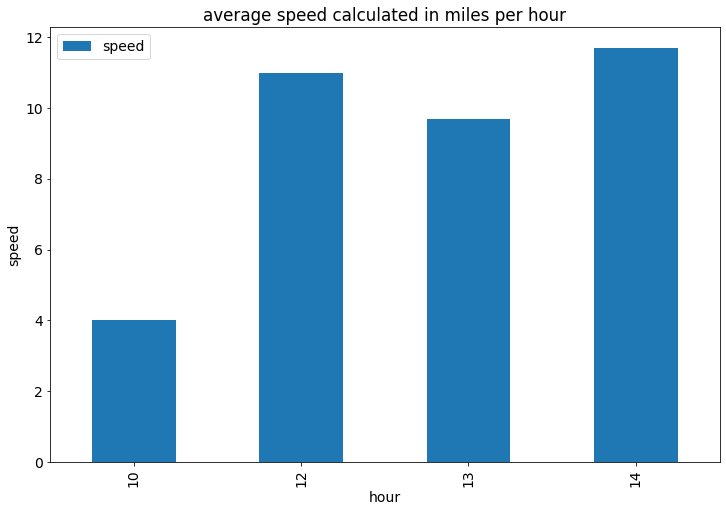

In [215]:

ax = avgspeed_df.plot(kind="bar", x="hour", y="speed")
ax.set_title("average speed calculated in miles per hour")
ax.set_xlabel("hour")
ax.set_ylabel("speed")

In [216]:
no_of_trips = """

#standardSQL
SELECT
  TIMESTAMP_TRUNC(tpep_pickup_datetime,
    MONTH) month,
  COUNT(*) trips
FROM
  `medavarapusumanth.sample.test1`
GROUP BY
  1
ORDER BY
  1

"""
num_trips_df = client.query(no_of_trips).to_dataframe()
num_trips_df.head()

,month,trips
0,2019-07-01 00:00:00+00:00,1004


Text(0, 0.5, 'trips')

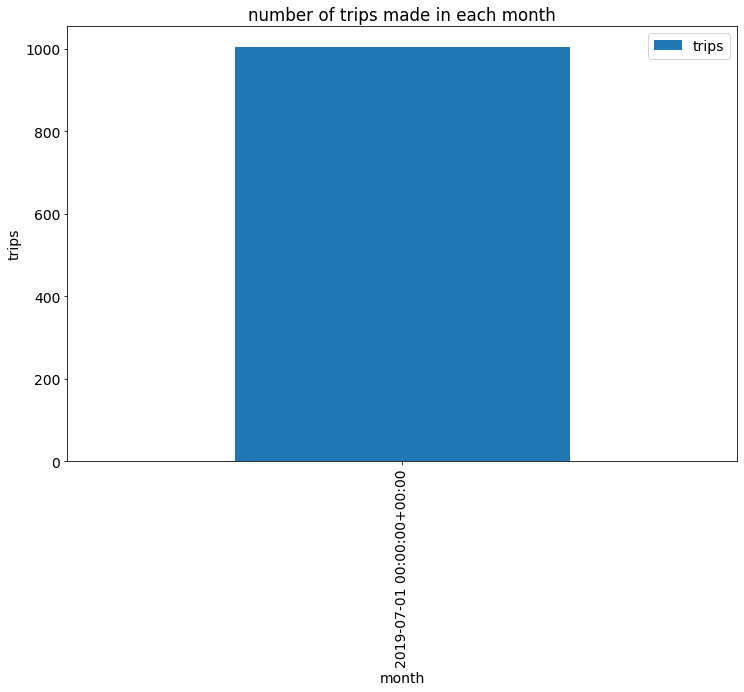

In [222]:
# Bar plot Month vs No of Trips
ax = num_trips_df.plot(kind="bar", x="month", y="trips")
ax.set_title("number of trips made in each month")
ax.set_xlabel("month")
ax.set_ylabel("trips")

In [218]:
fare_and_dist = """

SELECT
  trip_distance,
  fare_amount,
  
FROM
  #`medavarapusumanth.sample.test1`
  `nyc-tlc.yellow.trips`
WHERE
    MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 5000)= 1

"""
fare_amt_dist_df = client.query(fare_and_dist).to_dataframe()
fare_amt_dist_df.head()

,trip_distance,fare_amount
0,5.10,17.0
1,4.83,17.0
2,4.69,18.0
3,6.15,19.0
4,5.30,20.0


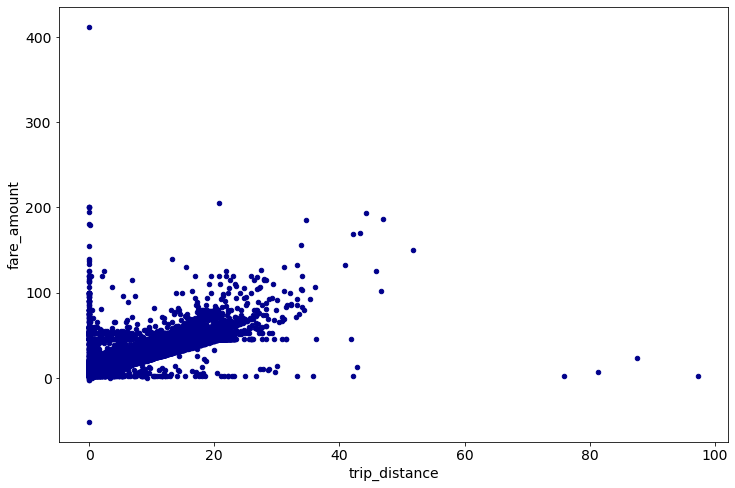

In [219]:
#scatter plot Trip_distance Vs Fare Amount
ax1 = fare_amt_dist_df.plot.scatter(x='trip_distance',
                      y='fare_amount',
                      c='DarkBlue')

In [220]:
test = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount, -- label
  EXTRACT(DAYOFWEEK from pickup_datetime) AS dayofweek,
  EXTRACT(HOUR from pickup_datetime) AS hourofday
FROM
      `nyc-tlc.yellow.trips`
WHERE
    MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 5000)= 1


"""
    
trial_df = client.query(test).to_dataframe()
trial_df.head()

,fare_amount,dayofweek,hourofday
0,7.0,2,0
1,26.5,5,0
2,5.3,6,0
3,9.7,6,0
4,3.7,5,0


## Proof of Concept

In [179]:
import pandas as pd
df1 = pd.read_csv ('C:/Users/sumanth/Downloads/bquxjob_4ef3610d_17e1698f810.csv')
df1.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount,store_and_fwd_flag
0,VTS,2009-09-23T00:27:00Z,2009-09-23T00:28:00Z,-74.027698,40.624417,-74.027698,40.624418,NaN,2,0.00,CRD,2.5,0.5,NaN,NaN,51.30,0.0,54.30,NaN
1,VTS,2013-01-24T08:46:00Z,2013-01-24T08:50:00Z,-74.010235,40.719398,-74.011127,40.714970,1.0,1,0.42,CRD,3.5,0.0,0.5,NaN,0.00,0.0,4.00,NaN
2,CMT,2015-03-24T15:51:54Z,2015-03-24T15:53:50Z,-73.978020,40.786297,-73.975533,40.792149,1.0,1,0.50,CRD,3.5,0.0,0.5,0.3,0.85,0.0,5.15,N
3,DDS,2009-03-09T05:52:52Z,2009-03-09T05:56:47Z,-73.901685,40.762523,-73.901685,40.762523,NaN,1,1.00,CSH,4.5,0.0,NaN,NaN,0.00,0.0,4.50,NaN
4,VTS,2009-04-06T09:46:00Z,2009-04-06T09:50:00Z,-73.958345,40.778523,-73.954532,40.786757,NaN,5,0.67,CSH,4.5,0.0,NaN,NaN,0.00,0.0,4.50,NaN


In [182]:
from pandasql import sqldf
mysql = lambda q: sqldf(q, globals())
get_day_hour = mysql("SELECT (tolls_amount + fare_amount) AS fare_amount,strftime('%w',pickup_datetime) AS dayofweek,strftime('%H',pickup_datetime) AS hourofday FROM df1 LIMIT 5;")
get_day_hour.head()

,fare_amount,dayofweek,hourofday
0,2.5,3,00
1,3.5,4,08
2,3.5,2,15
3,4.5,1,05
4,4.5,1,09


## Exploratory Data Analysis

In [183]:
trips = """
SELECT
  strftime('%w',pickup_datetime) AS dayofweek,
  COUNT(*) nooftrips
FROM
  df1
GROUP BY
  1
ORDER BY
  1;

"""
day_and_no_of_trips = mysql(trips)
day_and_no_of_trips.head()

,dayofweek,nooftrips
0,0,3668
1,1,3789
2,2,3917
3,3,3922
4,4,4165


[Text(0, 0, 'Sun'),
 Text(1, 0, 'Mon'),
 Text(2, 0, 'Tues'),
 Text(3, 0, 'wed'),
 Text(4, 0, 'Thur'),
 Text(5, 0, 'Fri'),
 Text(6, 0, 'sat')]

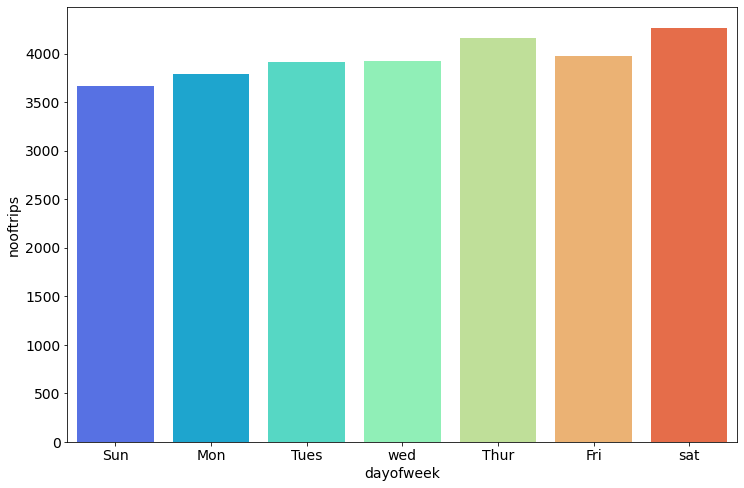

In [184]:
import seaborn as sns
#plot no of trips
g = sns.barplot(x="dayofweek", y="nooftrips", data=day_and_no_of_trips,palette='rainbow',)
g.set_xticklabels(['Sun','Mon','Tues','wed','Thur','Fri','sat'])


In [27]:
avgfare = """
SELECT
  strftime('%w',pickup_datetime) AS dayofweek,
  AVG(fare_amount) avg_fare_amount
FROM
  df1
GROUP BY
  1
ORDER BY
  1;

"""
day_and_avg_fare = mysql(avgfare)
day_and_avg_fare.head()

,dayofweek,avg_fare_amount
0,0,11.107197
1,1,10.905263
2,2,10.877470
3,3,11.120143
4,4,11.145714


[Text(0, 0, 'Sun'),
 Text(1, 0, 'Mon'),
 Text(2, 0, 'Tues'),
 Text(3, 0, 'wed'),
 Text(4, 0, 'Thur'),
 Text(5, 0, 'Fri'),
 Text(6, 0, 'sat')]

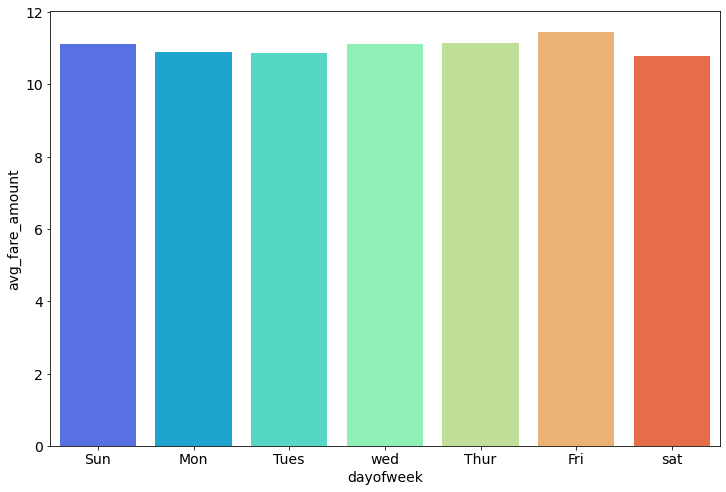

In [187]:
#plot average fare amount
g_avgfare = sns.barplot(x="dayofweek", y="avg_fare_amount", data=day_and_avg_fare,palette='rainbow',)
g_avgfare.set_xticklabels(['Sun','Mon','Tues','wed','Thur','Fri','sat'])

## Hourly Analysis

In [185]:
hour_avgfare = """
SELECT
  strftime('%H',pickup_datetime) AS hourofday,
  COUNT(*) nooftrips
FROM
  df1
GROUP BY
  1
ORDER BY
  1;

"""
hour_day_and_avg_fare = mysql(hour_avgfare)
hour_day_and_avg_fare.head()

,hourofday,nooftrips
0,00,1170
1,01,774
2,02,770
3,03,362
4,04,271


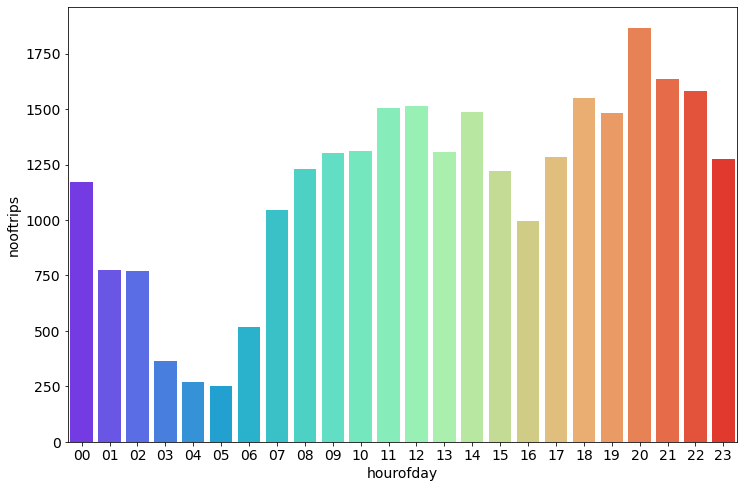

In [186]:
g_hour_avgfare = sns.barplot(x="hourofday", y="nooftrips", data=hour_day_and_avg_fare,palette='rainbow',)

## Trip Distance Vs Fare Amount

In [188]:
trip_dist_fare = """
SELECT
  trip_distance,
  fare_amount
FROM
  df1
WHERE
 fare_amount > 2.5;

"""
box_trip_dist_fare = mysql(trip_dist_fare)
box_trip_dist_fare.head()

,trip_distance,fare_amount
0,0.42,3.5
1,0.50,3.5
2,1.00,4.5
3,0.67,4.5
4,0.96,4.5


<AxesSubplot:xlabel='trip_distance', ylabel='fare_amount'>

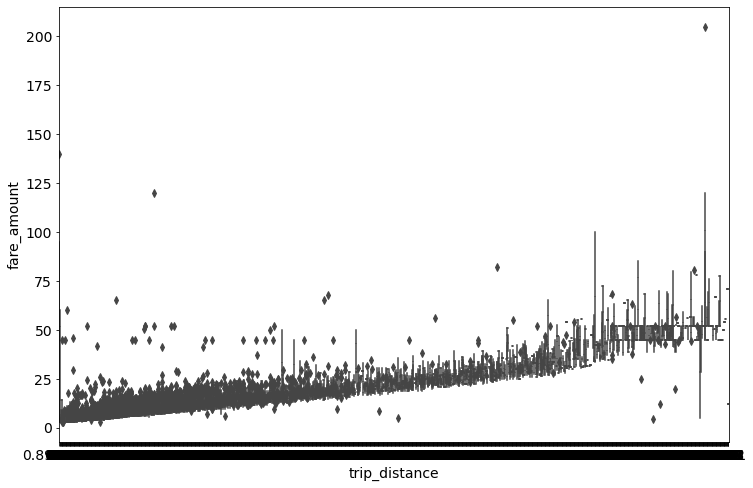

In [189]:
# Boxplot to avoid showing outliers
sns.boxplot(x="trip_distance", y="fare_amount",data=box_trip_dist_fare)

<AxesSubplot:xlabel='trip_distance', ylabel='fare_amount'>

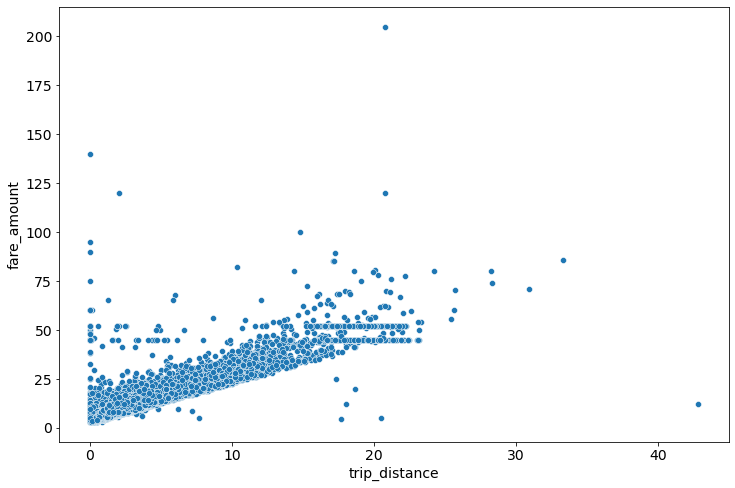

In [190]:
#scatterplot showing Outliers
sns.scatterplot(x="trip_distance", y="fare_amount",data=box_trip_dist_fare)

# Find Outliers and Remove using  IQR(Q3-Q1) to improve performance

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3-Q1
    lower_range = Q1-(1.5 * IQR)
    upper_range = Q3+(1.5 * IQR)
    return lower_range,upper_range

In [51]:
lowerbound,upperbound = outlier_treatment(df1.fare_amount)
print(lowerbound)
print(upperbound)

-3.75
22.25


### Displaying the outlier values

In [53]:
#columns which have outlier values 
df1[(df1.fare_amount < lowerbound) | (df1.fare_amount > upperbound)]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount,store_and_fwd_flag
90,CMT,2014-02-20T21:10:20Z,2014-02-20T21:41:13Z,-73.989235,40.754169,-73.849359,40.728332,1.0,1,8.70,CRD,27.0,0.5,0.5,NaN,6.66,5.33,39.99,N
91,CMT,2013-06-18T14:38:32Z,2013-06-18T15:25:01Z,-73.983354,40.738925,-74.008761,40.711008,1.0,1,4.20,CRD,29.0,0.0,0.5,NaN,6.00,0.00,35.50,N
92,VTS,2013-05-14T14:27:00Z,2013-05-14T15:02:00Z,-73.944442,40.824057,-73.797577,40.644730,2.0,1,18.44,CSH,52.0,0.0,0.5,NaN,0.00,5.33,57.83,NaN
93,CMT,2014-09-28T21:58:49Z,2014-09-28T22:43:31Z,-73.776808,40.645093,-73.970839,40.785749,2.0,1,20.50,CRD,52.0,0.0,0.5,NaN,14.45,5.33,72.28,N
94,CMT,2014-04-05T15:35:50Z,2014-04-05T16:45:24Z,-73.783021,40.644399,-74.009342,40.715497,2.0,1,21.00,CRD,52.0,0.0,0.5,NaN,14.45,5.33,72.28,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27672,VTS,2013-05-14T08:59:00Z,2013-05-14T09:33:00Z,-74.007040,40.715857,-73.963192,40.775192,1.0,1,7.41,CRD,27.5,0.0,0.5,NaN,2.00,0.00,30.00,NaN
27673,CMT,2014-04-14T16:59:09Z,2014-04-14T17:38:04Z,-73.984272,40.759930,-73.981265,40.741573,1.0,4,6.50,CSH,28.5,1.0,0.5,NaN,0.00,0.00,30.00,N
27674,CMT,2013-05-20T17:50:01Z,2013-05-20T18:30:57Z,-74.002414,40.744926,-73.962984,40.661884,1.0,1,8.70,CRD,28.5,1.0,0.5,NaN,9.00,0.00,39.00,N
27675,VTS,2012-05-07T10:51:00Z,2012-05-07T11:47:00Z,-73.985412,40.768180,-74.006855,40.711452,1.0,2,7.16,CSH,30.5,0.0,0.5,NaN,0.00,0.00,31.00,NaN


In [191]:
# Drop the outliers 
df1.drop(df1[ (df1.fare_amount > upperbound) | (df1.fare_amount < lowerbound) ].index , inplace=True)

## Scatter plot Trip Distance vs Fare Amount after removing Outliers

In [193]:
trip_dist_fare = """
SELECT
  trip_distance,
  fare_amount
FROM
  df1
WHERE
    trip_distance > 0
    AND pickup_longitude < -73
    AND dropoff_longitude > -75
    AND dropoff_longitude < -73
    AND pickup_latitude > 40
    AND pickup_latitude < 42
    AND dropoff_latitude > 40
    AND dropoff_latitude < 42;

"""
box_trip_dist_fare = mysql(trip_dist_fare)
box_trip_dist_fare.head()

,trip_distance,fare_amount
0,0.42,3.5
1,0.50,3.5
2,1.00,4.5
3,0.67,4.5
4,0.96,4.5


<AxesSubplot:xlabel='trip_distance', ylabel='fare_amount'>

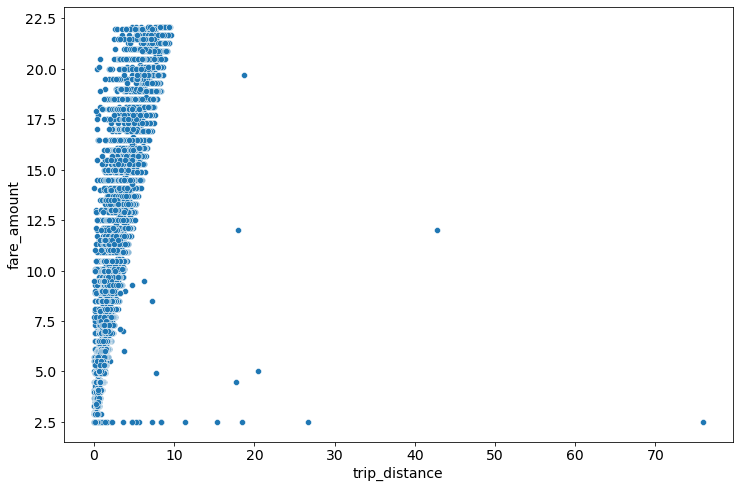

In [194]:
# scatter plot after removing outliers
sns.scatterplot(x="trip_distance", y="fare_amount",data=box_trip_dist_fare)

# Random forest algorithm

In [159]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import sklearn

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [146]:
# train features
features = """
SELECT
  strftime('%H',pickup_datetime) AS hourofday,
  strftime('%w',pickup_datetime) AS dayofweek,
  pickup_longitude,
  pickup_latitude,
  dropoff_longitude,
  trip_distance,
  dropoff_latitude,
  passenger_count
FROM
  df1;

"""
x = mysql(features)


In [198]:
sum_column = df1["fare_amount"] + df1["tolls_amount"]
df1["total_fare"] = sum_column
y = df1.total_fare
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=12)


### Train the model

In [199]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [200]:
rf.feature_importances_

array([0.03298135, 0.01417701, 0.02957501, 0.02893447, 0.03010986,
       0.82389522, 0.0343475 , 0.00597957])

### Feature Importance plot to determine which column is important to consider

<BarContainer object of 8 artists>

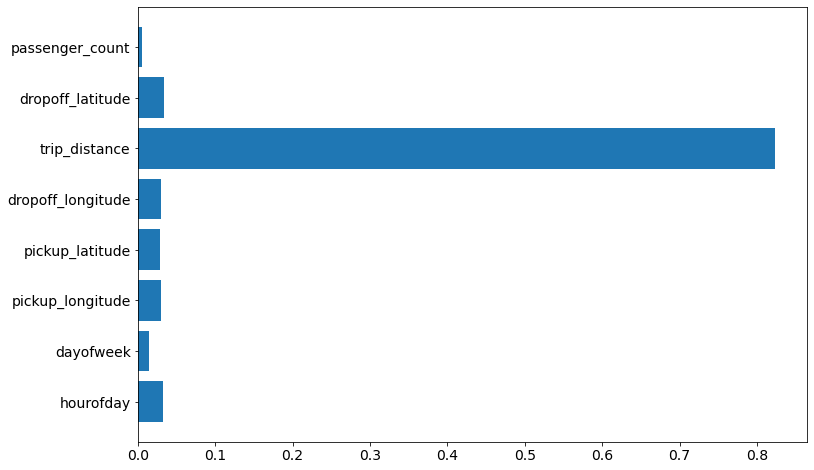

In [201]:
from numpy import array
feature_names = array(['hourofday','dayofweek','pickup_longitude','pickup_latitude','dropoff_longitude','trip_distance','dropoff_latitude','passenger_count'])
plt.barh(feature_names, rf.feature_importances_)

### Find Root Mean Square Error for Random Forest Algorithm

In [202]:
import math
actual = y_test
predicted = rf.predict(X_test)

mse = sklearn.metrics.mean_squared_error(actual, predicted)

rmse = math.sqrt(mse)

print(rmse)


1.6963530786634626


# Multiple Linear Regression Algorithm

In [203]:
# train features
features = """
SELECT
  strftime('%H',pickup_datetime) AS hourofday,
  strftime('%w',pickup_datetime) AS dayofweek,
  pickup_longitude,
  pickup_latitude,
  dropoff_longitude,
  trip_distance,
  dropoff_latitude,
  passenger_count 
FROM
  df1;

"""
x1 = mysql(features)

In [204]:
# multiple linear regression
from sklearn.linear_model import LinearRegression
y1 = df1.total_fare
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x1, y1, test_size=0.25, random_state=12)

# instantiate and fit
lm2 = LinearRegression()
lm2.fit(x1, y1)

# print the coefficients
print(lm2.intercept_)
print(lm2.coef_)

4.168101295209502
[ 1.33441272e-02  5.47102067e-02  7.26305750e-04  3.86861931e-03
 -6.51417601e-04  2.14194395e+00 -3.24377008e-03  1.78972882e-02]


In [205]:
actual1 = y_test_1
predicted1 = rf.predict(X_test_1)

mse1 = sklearn.metrics.mean_squared_error(actual1, predicted1)

rmse1 = math.sqrt(mse1)

print(rmse1)

1.6963530786634626


In [206]:
# pair the feature names with the coefficients
feature_cols = ['hourofday','dayofweek','pickup_longitude','pickup_latitude','dropoff_longitude','trip_distance','dropoff_latitude','passenger_count']
list(zip(feature_cols, lm2.coef_))


[('hourofday', 0.013344127229185444),
 ('dayofweek', 0.05471020670108412),
 ('pickup_longitude', 0.0007263057500609335),
 ('pickup_latitude', 0.0038686193119693013),
 ('dropoff_longitude', -0.0006514176006987595),
 ('trip_distance', 2.141943950418873),
 ('dropoff_latitude', -0.0032437700824927695),
 ('passenger_count', 0.017897288249641933)]

In [207]:
data = """
SELECT
  strftime('%H',pickup_datetime) AS hourofday,
  strftime('%w',pickup_datetime) AS dayofweek,
  pickup_longitude,
  pickup_latitude,
  dropoff_longitude,
  trip_distance,
  dropoff_latitude,
  passenger_count,
  total_fare 
FROM
  df1;

"""
data1 = mysql(data)

In [208]:
import statsmodels.formula.api as smf
lm1 = smf.ols(formula='total_fare ~ hourofday+dayofweek+pickup_longitude+pickup_latitude+dropoff_longitude+trip_distance+dropoff_latitude+passenger_count', data=data1).fit()
# print the coefficients
lm1.params

Intercept            3.787854
hourofday[T.01]     -0.154424
hourofday[T.02]     -0.366366
hourofday[T.03]     -1.087776
hourofday[T.04]     -0.450214
hourofday[T.05]     -0.546290
hourofday[T.06]     -0.655344
hourofday[T.07]     -0.077984
hourofday[T.08]      0.768527
hourofday[T.09]      0.866786
hourofday[T.10]      0.787375
hourofday[T.11]      0.756850
hourofday[T.12]      0.748673
hourofday[T.13]      0.823937
hourofday[T.14]      0.921360
hourofday[T.15]      0.736779
hourofday[T.16]      0.627254
hourofday[T.17]      0.705401
hourofday[T.18]      0.751298
hourofday[T.19]      0.488424
hourofday[T.20]      0.188089
hourofday[T.21]      0.092684
hourofday[T.22]     -0.004567
hourofday[T.23]     -0.005796
dayofweek[T.1]       0.056523
dayofweek[T.2]       0.317168
dayofweek[T.3]       0.409094
dayofweek[T.4]       0.471253
dayofweek[T.5]       0.411611
dayofweek[T.6]       0.311743
pickup_longitude     0.000463
pickup_latitude      0.000142
dropoff_longitude    0.000146
trip_dista

### Adjusted R-squared value is the actual value

In [209]:
# print a summary of the fitted model
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             total_fare   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1596.
Date:                Sun, 02 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:03:43   Log-Likelihood:                -57914.
No. Observations:               25453   AIC:                         1.159e+05
Df Residuals:                   25417   BIC:                         1.162e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.7879      0.136     27.918      0.000       3.522       4.054
hourofday[T.01]      -0.1544      0.114     -1.357      0.175      -0.378       0.069
hourofday[T.02]      -0.3664      0.115     -3.193      0.001      -0.591      -0.141
hourofday[T.03]      -1.0878      0.150     -7.276      0.000      -1.381      -0.795
hourofday[T.04]      -0.4502      0.172     -2.618      0.009      -0.787      -0.113
hourofday[T.05]      -0.5463      0.178     -3.067      0.002      -0.895      -0.197
hourofday[T.06]      -0.6553      0.133     -4.938      0.000      -0.915      -0.395
hourofday[T.07]      -0.0780      0.106     -0.737      0.461      -0.285       0.129
hourofday[T.08]       0.7685      0.101      7.603      0.000       0.570       0.967
hourofday[T.09]       0.8668      0.099      8.719      0.000       0.672       1.062
hourofday[T.10]       0.7874      0.099      7.938      0.000       0.593       0.982
hourofday[T.11]       0.7569      0.097      7.836      0.000       0.568       0.946
hourofday[T.12]       0.7487      0.096      7.794      0.000       0.560       0.937
hourofday[T.13]       0.8239      0.100      8.275      0.000       0.629       1.019
hourofday[T.14]       0.9214      0.097      9.500      0.000       0.731       1.111
hourofday[T.15]       0.7368      0.102      7.241      0.000       0.537       0.936
hourofday[T.16]       0.6273      0.107      5.874      0.000       0.418       0.837
hourofday[T.17]       0.7054      0.100      7.069      0.000       0.510       0.901
hourofday[T.18]       0.7513      0.095      7.894      0.000       0.565       0.938
hourofday[T.19]       0.4884      0.096      5.064      0.000       0.299       0.677
hourofday[T.20]       0.1881      0.092      2.039      0.041       0.007       0.369
hourofday[T.21]       0.0927      0.095      0.976      0.329      -0.093       0.279
hourofday[T.22]      -0.0046      0.095     -0.048      0.962      -0.191       0.182
hourofday[T.23]      -0.0058      0.101     -0.058      0.954      -0.203       0.191
dayofweek[T.1]        0.0565      0.059      0.964      0.335      -0.058       0.172
dayofweek[T.2]        0.3172      0.058      5.478      0.000       0.204       0.431
dayofweek[T.3]        0.4091      0.058      7.059      0.000       0.296       0.523
dayofweek[T.4]        0.4713      0.057      8.229      0.000       0.359       0.583
dayofweek[T.5]        0.4116      0.058      7.143      0.000       0.299       0.525
dayofweek[T.6]        0.3117      0.056      5.576      0.000       0.202       0.421
pickup_longitude      0.0005      0.001      0.313      0.754      -0.002       0.003
pickup_latitude       0.0001      0.011      0.013      0.989      -0.021       0.021
dropoff_longitude     0.0001      0.002      0.080      0.936      -0.003

# Conclusion

### Applied Random Forest Algorithm to find feature importance and compare with multiple linear Regression.For Multiple linear regression,Done analysis with outliers and without outliers.    RMSE with outliers "5.12"(after improving Feature Engineering by considering within NYC), which is significantly better than 9.47 initially.     RMSE without outliers "1.69" for both algorithms